In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2
import os
import keras
from glob import glob
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [2]:
gpus = tf.config.list_physical_devices('GPU')

In [3]:
for i in gpus:
    i = tf.config.experimental.set_memory_growth(i, True)

In [4]:
batch_size = 3
lr = 1e-4
height = 1024//2
width = 1280//2

In [5]:
train_path = './PS3_Train/PS3_Train/seq_1/'
valid_path = './PS3_Train/PS3_Train/seq_2/'
files_dir = os.path.join('files', 'non-aug')

In [6]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [7]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [8]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

In [9]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding = 'same', activation='sigmoid')(d4)
    model = Model(inputs, outputs, name='UNET')
    return model

In [10]:
train_x = glob(os.path.join(train_path, 'frames', '*'))
train_y = glob(os.path.join(train_path, 'labels', '*'))

valid_x = glob(os.path.join(valid_path, 'frames', '*'))
valid_y = glob(os.path.join(valid_path, 'labels', '*'))

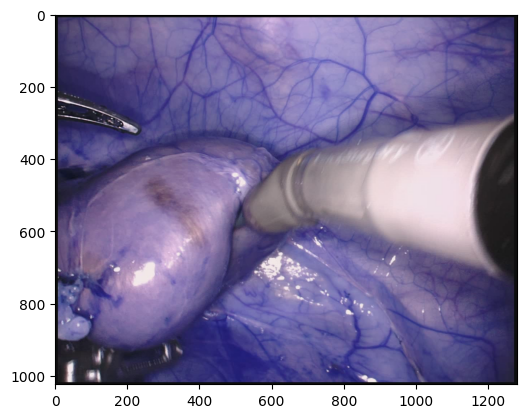

In [11]:
plt.imshow(cv2.imread(train_x[0]))

In [12]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x/255.0
    return x

In [13]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (width, height))
    x = 
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [15]:
import cv2
import numpy as np

def convert_to_binary(image_path : str):
    image = cv2.imread(image_path,0)
    numpy_image = np.array([[255 if pixel == 29 else 0 for pixel in row]for row in image])
    return numpy_image.astype(np.uint8)

img_path = './PS3_Train/PS3_Train/seq_1/labels/frame000.png'
binary_image = convert_to_binary(img_path)

In [16]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])

    return x, y

In [17]:
def tf_dataset(x, y, batch=16):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [18]:
# (train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)
print(f'Train: {len(train_x)} - {len(train_y)}')
print(f'Valid: {len(valid_x)} - {len(valid_y)}')

Train: 149 - 149
Valid: 149 - 149


In [19]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [20]:
for x, y in valid_dataset:
    print(x.shape, y.shape)

(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 3) (2, 256, 320, 1)
(2, 256, 320, 

In [21]:
input_shape = (height, width, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 320, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 320, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [22]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['acc'])

In [23]:
model_file = os.path.join('./PS3_Train/PS3_Train/seq_1/model/', 'unet.h5')
log_file = os.path.join('./PS3_Train/PS3_Train/seq_1/log/', 'log.csv')

In [24]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

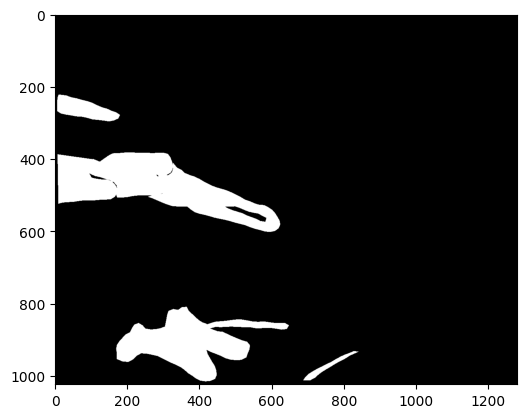

In [25]:
img_path = './PS3_Train/PS3_Train/seq_1/labels/frame020.png'
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
binary = cv2.bitwise_not(binary)
binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
result = np.where(binary == [0, 0, 0], [255, 255, 255], image)
plt.imshow(result)

In [27]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 0.2110 - acc: 0.7974
Epoch 1: val_loss improved from 0.42435 to 0.24836, saving model to ./PS3_Train/PS3_Train/seq_1/model\unet.h5
75/75 [==============================] - 12s 163ms/step - loss: 0.2110 - acc: 0.7974 - val_loss: 0.2484 - val_acc: 0.8006 - lr: 1.0000e-04
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.1913 - acc: 0.7973
Epoch 2: val_loss improved from 0.24836 to 0.17767, saving model to ./PS3_Train/PS3_Train/seq_1/model\unet.h5
75/75 [==============================] - 12s 163ms/step - loss: 0.1913 - acc: 0.7973 - val_loss: 0.1777 - val_acc: 0.8006 - lr: 1.0000e-04
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.1796 - acc: 0.7971
Epoch 3: val_loss improved from 0.17767 to 0.14595, saving model to ./PS3_Train/PS3_Train/seq_1/model\unet.h5
75/75 [==============================] - 12s 163ms/step - loss: 0.1796 - acc: 0.7971 - val_loss: 0.1460 - val_acc: 0.8006 - l